In [ ]:
from studies.study_factory import StudyFactory
from dataloader.dataloader import DataLoader

dataloader = DataLoader(
    buffer_size=10,
    max_cache_size_gb=100,
    cache_dir="cache",
    notch_filter=True,
    frequency_bands={"all": (0.5, 100)},
    scaling="both",
    brain_clipping=20,
    baseline_window=0.5,
    new_freq=100,
    batch_types={"audio": 2},
    batch_kwargs={
        'audio': {
            'max_random_shift': 1,
            'window_size': 4,
            'window_stride': 1, 
            'audio_sample_rate': 16000,
            'hop_length': 160,
            'audio_processor': "openai/whisper-large-v3"
        }
    },
)

2024-12-13 17:23:39,245	INFO worker.py:1821 -- Started a local Ray instance.


(raylet) Spilled 2934 MiB, 2 objects, write throughput 1209 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(raylet) Spilled 4289 MiB, 3 objects, write throughput 1405 MiB/s.
(raylet) Spilled 10456 MiB, 7 objects, write throughput 1068 MiB/s.


In [2]:
study = StudyFactory.create_study(
    study_name='schoffelen2022',
    batch_type='audio',
    path='data/schoffelen2022',
    cache_enabled=True,
    max_cache_size=200, # in items
)

Loading Schoffelen2022 with batch type audio


In [3]:
from itertools import chain
import random

flat_recordings = list(chain.from_iterable(chain.from_iterable(study.recordings)))

In [4]:
# # Start background fetching
import time


dataloader.start_fetching(flat_recordings, cache=True)

# Process batches as they become available
try:
    batches, recs, start_time = 0, 0, time.time()
    print(f'Total recordings: {len(flat_recordings)}')
    
    while True:
        batch = dataloader.get_recording()
        
        if batch is None:
            break
        
        brain = batch.brain_segments['all']
        batches += brain.shape[0]
        recs += 1
        
        break
        
        if recs % 1 == 0:
            print(f"Batch {batches} ({recs} recordings) processed in {time.time() - start_time:.2f}s")
            print(
                f"Average processing time per recording: {(time.time() - start_time) / recs:.2f}s"
            )
            print(
                f"Average processing time per batch: {(time.time() - start_time) / batches:.2f}s"
            )
        
except KeyboardInterrupt:
    print("Interrupted")
    dataloader.stop()
except Exception as e:
    print("Error", e)
    dataloader.stop()

Total recordings: 30


In [5]:
batch.recording.info["chs"][0]["loc"][:3]

array([-0.02962777,  0.05536646,  0.081     ])

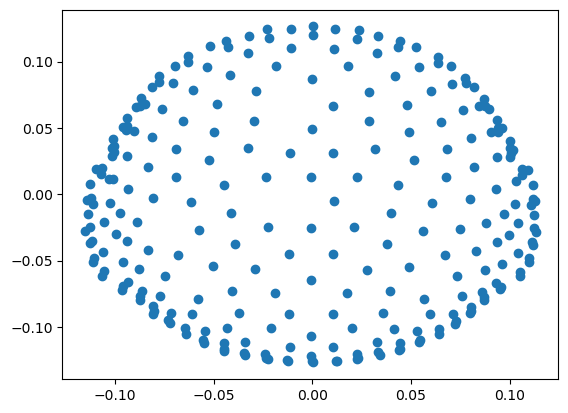

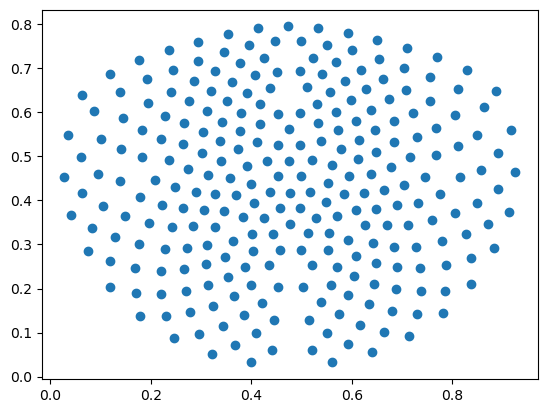

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import mne

# Plot sensor locations

locs = [ch["loc"][:3] for ch in batch.recording.info["chs"]]
locs = np.array(locs)
plt.scatter(locs[:, 0], locs[:, 1])
plt.show()

layout = mne.find_layout(batch.recording.info)
layout = layout.pos[:269, :2]
plt.scatter(layout[:, 0], layout[:, 1])
plt.show()

In [ ]:
# from config import SimpleConvConfig
# from models.simpleconv import SimpleConv
# import torch

# config = SimpleConvConfig(
#     # Str to list of possible conditions
#     conditions={
#         "studies": ["gwilliams2023", "schoffelen2022"],
#     },
#     # Channels
#     in_channels=208,
#     out_channels=128,
#     hidden_dim=256,
#     dropout=0.3,
#     # Sensor layout settings
#     layout_dim=2,
#     layout_proj=False,
#     layout_scaling="minmax",
#     # Merger with spatial attn
#     merger=True,
#     merger_emb_dim=2048,
#     merger_channels=256,
#     merger_dropout=0.3,
#     merger_conditional=None,
#     # Inital
#     initial_linear=256,
#     initial_depth=1,
#     # Conditional layers
#     conditional_layers=True,
#     conditional_layers_dim="hidden_dim",  # or hidden_dim
#     # Conv layer overall structure
#     depth=4,
#     kernel_size=3,
#     growth=1.0,
#     dilation_growth=2,
#     dilation_period=5,
#     glu=1,
#     conv_dropout=0.2,
#     dropout_input=0.2,
#     batch_norm=True,
#     # Transformers Encoders
#     transformer_encoder_emb="groupconv",
#     transformer_encoder_layers=1,
#     transformer_encoder_heads=8,
#     transformer_encoder_concat_spectrals=True,
#     transformer_encoder_bins=16,
#     transformer_encoder_spectral_dim=256,
#     # Transformer Decoders
#     transformer_decoder_emb="groupconv",
#     transformer_decoder_layers=1,
#     transformer_decoder_heads=8,
#     transformer_decoder_dim=256,
# )

# model = SimpleConv(config)


TransEncoder 	Params: 3290112
		Spec: 256, 		Emb: groupconv, 	Bins: 16
		Layers: 1, 		D_model: 512, 		Nhead: 8

TransDecoder 	Params: 1087104
		Emb: groupconv, 	Layers: 1, 		D_model: 256
		Nhead: 8, 		Mel_bins: 128

SimpleConv: 	Params: 7725056, 	cond: ['studies']
		Merger: True, 		Merger chan: 256
		Conv blocks: 4, 	Channels: 256, 		Params: 2363904


In [ ]:
# out = model(
#     x=batch.brain_segments["all"][:2],
#     recording=batch.recording,
#     conditions={"studies": "schoffelen2022"},
#     mel=batch.audio_segments[:2],
#     train=True,
# )

GroupedConv: x: torch.Size([2, 400, 512]), pos_emb: torch.Size([2, 400, 512])
Embedding shape: torch.Size([2, 400, 512]), attn_mask: torch.Size([2, 400])
Encoder output shape: torch.Size([2, 512, 400])
GroupedConv: x: torch.Size([2, 400, 128]), pos_emb: torch.Size([2, 400, 128])
